## Exploring neighborhoods & Chinese restaurants in Toronto.
### Web-scraping, Foursquare API, Folium Map,  Machine Learning

As a two-week IBM Data Science professional certificate program Capstone Project, I will work on web-based datasets to get a taste of what a typical day of data scientist is like in real life. Main objectives of this project is to define a business problem, look for data in the web and, use Foursquare API to compare different neighborhoods of Toronto to figure out the status quo of Asian & Chinese restaurant and which neighborhood is most suitable for starting a new Chinese restaurant. We will go through all the process step by step from problem description, data preparation, analyses and finally provide a conclusion that can be beneficial to the business stakeholders to make their decisions.

### 1. Background & Description of the Business Problem.

#### Problem Statement: status quo & prospects of starting a Chinese restaurant in Toronto, Canada.

Toronto, the capital of the province of Ontario, is the most populated Canadian city. Its diversity is reflected in Toronto’s ethnic neighborhoods such as Chinatown, Corso Italia, Greektown, Kensington Market, Koreatown, Little India, Little Italy, Little Jamaica, Little Portugal & Roncesvalles. it is one of the best places to start an Chinese restaurant as one of the most immigrant-friendly cities in North America. \
\
Unlike other business, e.g. stock, real estate, the demand for food is continuously high, especially in a Internationally renown city. Besides, Chinese is the third largest population group in local Toronto neighborhoods and people within this group have strong need for food from Chinese restaurant. Reasoning above supports that Toronto is a ideal location to choose a neighborhood and start a restaurant from. So what is the status quo of local restaurants in Toronto? In which neighborhood(s) is Chinese restaurant most popular?  and where should we start a Chinese restaurant? 

#### Target Audience
Who's going to be interested in this problem? And to whom this problem will be beneficial? as I dive into the problem and determine the optimistic location to start a restaurant:
1. Business personnel who wants to invest or open up an Chinese restaurant in Toronto. This analysis will be a preliminary guide to start or expand restaurants targeting the Chinese customers. 
2. Crowd who wants to find a Chinese restaurant to dine in.  
3. Data/business Analyst or Data Scientists, who wish to analyze the neighborhoods of Toronto using Exploratory Data Analysis and other statistical & machine learning techniques to obtain all the necessary data, perform some operations on it and, finally be able to tell a cogent story out of it.

In [ ]:
import pandas as pd
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

### 2. Data acquisition & preparation

INSTRUCTION: **Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.**

#### 2.1 Data source
* “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to get Postal code, borough & the name of all the neighborhoods about the neighborhoods in Toronto (use only assigned boroughs).  
* “https://cocl.us/Geospatial_data.csv” file to get all the geographical coordinates of the neighborhoods.
* “Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) wiki page to get demographic distribution of population by ethnicity, which will be helpful in identifying the suitable neighborhood to open a new Chinese restaurant.
* Geographic data using Foursquare’s API explore-mode to fetch details about the venues in Toronto and with regard to venues' names, categories and locations (latitude and longitude).

Using Foursquare API (https://developer.foursquare.com/docs), following information is to be retrieved for each venue:
* Name: The name of the venue.
* Category: The category type as defined by the API.
* Latitude: The latitude value of the venue.
* Longitude: The longitude value of the venue.

#### 2.2 Data Cleaning
a) Scraping Toronto Neighborhoods Table from Wikipedia\
Scraped the “List of Postal code of Canada: M” in order to obtain the data about the Toronto & the Neighborhoods. \
\
Assumptions made to attain the below DataFrame: 
* Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
* Only the cells that have an assigned borough will be processed. 
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [3]:
can = pd.read_csv('canadaneighbor.csv').dropna(how='any',axis=0).reset_index(drop=True)
can = pd.DataFrame(can) # convert target dataset into pandas data frame
can.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


b) Adding geographical coordinates to the neighborhoods\
Next important step is adding the geographical coordinates to these neighborhoods. To do so I’m going to be using the Geospatial Data csv file provided above and combining it with the existing neighborhood dataframe by merging them on the postal code column.

In [6]:
can_cordinated = pd.read_csv('can_cordinated.csv').dropna(how='any',axis=0).reset_index(drop=True)
can_cordinated = pd.DataFrame(can_cordinated) # convert target dataset into pandas data frame
can_cordinated.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


c) Scrap the distribution of population from Wikipedia \
Scraped “Demographics of Toronto” to obtain the data about the Toronto & the Neighborhoods in it. Compared to all the neighborhoods in Toronto below given neighborhoods only had considerable amount of Chinese crowd. We are examining those neighborhood’s population to identify the densely populated neighborhoods with Chinese population.

In [5]:
# 1. Minority population percentage in Toronto by riding
df1 = pd.read_csv('minoritypercent.csv').loc[:,['Riding (2003 Redistribution)','2011 NHS']]
df1.rename(columns={'Riding (2003 Redistribution)':'Dist_neig','2011 NHS':'Percent'}, inplace=True)
df1.head()

,Dist_neig,Percent
0,Etobicoke-Lakeshore,23.8
1,Parkdale-High Park,25.6
2,St. Paul's,25.8
3,Etobicoke Centre,27.5
4,Eglinton-Lawrence,28.9


In [7]:
# 2. Minority population percentage in Toronto by Ethnic group
df2 = pd.read_csv('Top 20 Ethnic origins in the City of Toronto.csv').loc[:,['Top 20 Ethnic origins in the City of Toronto','Percentage']]
df2.rename(columns={'Top 20 Ethnic origins in the City of Toronto':'Ethnic group'}, inplace=True)
df2.head()

,Ethnic group,Percentage
0,Chinese,12.5
1,English,12.3
2,Canadian,12.0
3,Irish,9.8
4,Scottish,9.5


In [6]:
# 3. Minority population in EAST YORK
df3 = pd.read_csv('eastyork.csv')
df3.head()

,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3
0,Spadina-Fort York,"114,315",White,56.3,Chinese,14.8,South Asian,8.3,Black,5.1
1,Beaches-East York,"108,435",White,64.5,South Asian,10.9,Black,6.6,Chinese,5.7
2,Davenport,"107,395",White,66.9,Black,6.4,Chinese,5.9,Latin American,5.4
3,Parkdale-High Park,"106,445",White,72.4,Black,5.3,NaN,NaN,NaN,NaN
4,Toronto-Danforth,"105,395",White,65.5,Chinese,12.3,South Asian,5.4,Black,5.0


In [10]:
# 4. Minority population in NORTH YORK
df4 = pd.read_csv('northyork.csv')
df4.head()

,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3,Ethnic Group #5,%.4,Ethnic Group #6,%.5
0,Willowdale,"117,405",White,33.1,Chinese,25.3,West Asian,10.9,Korean,10.3,South Asian,5.9,Filipino,5.4
1,Eglinton-Lawrence,"112,925",White,67.7,Filipino,10.7,Black,5.5,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley North,"109,060",Chinese,31.3,White,29.4,South Asian,10.2,West Asian,7.6,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,"107,725",White,25.4,Black,22.8,Latin American,9.5,Southeast Asian,8.9,Filipino,5.5,NaN,NaN
4,York Centre,"103,760",White,53.1,Filipino,16.5,Black,7.9,Latin American,5.1,NaN,NaN,NaN,NaN


In [7]:
# 5. Minority population in SCARBOROUGH
df5 = pd.read_csv('scarborough.csv')
df5.head()

,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3,Ethnic Group #5,%.4
0,Scarborough Centre,"110,450",White,29.4,South Asian,25.6,Filipino,12.5,Black,9.6,Chinese,9.3
1,Scarborough Southwest,"108,295",White,42.0,South Asian,21.6,Black,11.2,Filipino,9.0,Chinese,5.8
2,Scarborough-Agincourt,"104,225",Chinese,45.8,White,19.1,South Asian,14.0,Black,6.3,Filipino,5.4
3,Scarborough-Rouge Park,"101,445",South Asian,32.6,White,26.8,Black,15.9,Filipino,8.7,NaN,NaN
4,Scarborough-Guildwood,"101,115",South Asian,33.2,White,27.6,Black,14.3,Filipino,7.9,Chinese,5.4


In [13]:
# 6. Minority population in ETOBICOKE & YORK
df6 = pd.read_csv('etobicoke&york.csv')
df6

,Riding,Population,Ethnic Group #1,%,Ethnic Group #2,%.1,Ethnic Group #3,%.2,Ethnic Group #4,%.3,Ethnic Group #5,%.4
0,Etobicoke-Lakeshore,"127,520",White,71.3,South Asian,5.5,Black,5.0,NaN,NaN,NaN,NaN
1,Etobicoke North,"116,960",South Asian,28.9,White,23.8,Black,23.4,NaN,NaN,NaN,NaN
2,Etobicoke Centre,"116,055",White,72.3,South Asian,5.9,Black,5.9,NaN,NaN,NaN,NaN
3,York South-Weston,"115,130",White,44.2,Black,23.2,Latin American,8.5,Filipino,5.9,South Asian,5.7


d) Get location data using Foursquare \
Foursquare API is very useful online application used my many developers & other applications like Uber etc. In this project I have used it to retrieve information about the places present in the neighborhoods of Toronto. The API returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 0.5km.

In [8]:
Toronto_asianchineserestaurant = pd.read_csv('Toronto_grouped.csv').loc[:,['Neighborhood','Asian Restaurant','Chinese Restaurant']].sort_values(by=['Asian Restaurant','Chinese Restaurant'],ascending=False)
Toronto_asianchineserestaurant.to_csv('Toronto_asianchineserestaurant.csv')
Toronto_asianchineserestaurant.head(20)

,Neighborhood,Asian Restaurant,Chinese Restaurant
22,Don Mills,0.074074,0.037037
48,"Little Portugal, Trinity",0.069767,0.000000
78,"The Annex, North Midtown, Yorkville",0.041667,0.000000
29,"First Canadian Place, Underground city",0.030000,0.000000
63,"Regent Park, Harbourfront",0.021277,0.000000
28,"Fairview, Henry Farm, Oriole",0.015385,0.000000
72,St. James Town,0.013158,0.000000
64,"Richmond, Adelaide, King",0.010753,0.000000
83,"Toronto Dominion Centre, Design Exchange",0.010000,0.010000
18,"Commerce Court, Victoria Hotel",0.010000,0.000000


### 3. Methodology and exploratory analysis
In this part, I'll delineate the purposes for acquisition of data sets in part 2, and articulate the analysis strategy of this analysis which consists the part of methodology. Besides, preliminary exploration is to be conducted to get a broad idea of the status quo of Chinese population and restaurants in the City of Toronto, so as to help identify the optimistic location or neighborhood to start a Chines restaurant. 

#### 3.1 Methodology

Starting a new business may be challenging, requiring not only early investment or financial input but a thorough plan taking into account where customers reside in, potential competition and team management, etc. In this project, we'll simply focus on choosing a suitable location for the potential stakeholder who's interested in opening a new Chinese restaurant in Toronto, and accordingly our attention should be placed on identifying neighborhood(s) with little competition and sufficient number of customers.   

##### 3.1.1 Why bother web-scraping demographic tables from wikipedia? 
The purpose of getting access to demographic tables in part 2 is to get a basic understanding of the distribution of minority population including Chinese in Toronto neighborhoods. Facilitated by bar plots and graphs, we are able to figure out population density of Chinese crowd in different neighborhoods across the city. Meanwhile, the distribution of Asian restaurants will also be considered as population groups of Asian origin may share food preference and Asian restaurants may pose potential competition neighborhood-wide which should subject to due consideration when choosing a ideal location to start a new restaurant. \
Overall, acquisition and cleaning of demographic data helps formulate basic understanding of the distribution of Chinese population in the City of Toronto.


##### 3.1.2 What would Foursquare API data provide us? 
Foursquare API is widely used for online application by many developers e.g. Uber. In this project I have used it to retrieve venue information present in the neighborhoods of Toronto. The API request returns a JSON file which we later turn into a data-frame after one-hot encoding. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 1000 meters. After cleaning, we can extract venue information, including Chinese restaurant by neighborhood (see Toronto_asianchineserestaurant data set in Section 2). Please note, I also scraped the wikipedia page about Postal Code of Canada to get postal codes for each neighborhood in Toronto, and by combining it with the data Geospatial_data we get longitude and latitude of each neighborhood which will be used here to extract hot spots information from Foursquare API.  \
In a nutshell, sending API request to Foursquare with latitude and longitude of each neighborhood and other parameters gives a feedback of Jason file containing venues information, Chinese/Asian restaurant in this case. With easy processing, a certain number(100) of hot spots(Chinese/Asian restaurant) within the specified radius(1000m) for each neighborhood are retrieved.  

##### 3.1.2 What would Folium map show? 
Folium is a powerful data visualization library in Python that was built primarily to help people visualize geospatial data. With Folium, one can create a map of any location in the world if its latitude and longitude values are known. With that being said, once granted access to coordinates of neighborhoods in Toronto, we are able to visualize different neighborhoods with specified labels interactively. It is a intuitive way to perceive what the distribution of Chinese restaurant looks like, and help cluster neighborhoods into categories based on their label (in this case the frequency of Chinese restaurants). Foursquare API results provide us with longitude and latitude of neighborhood, and K-means clustering provides valid label for each neighborhood. Bearing that in mind, we are ready to go explore!

#### 3.2 Exploratory analysis

##### 3.2.1 Distribution of Chinese population by neighborhood 

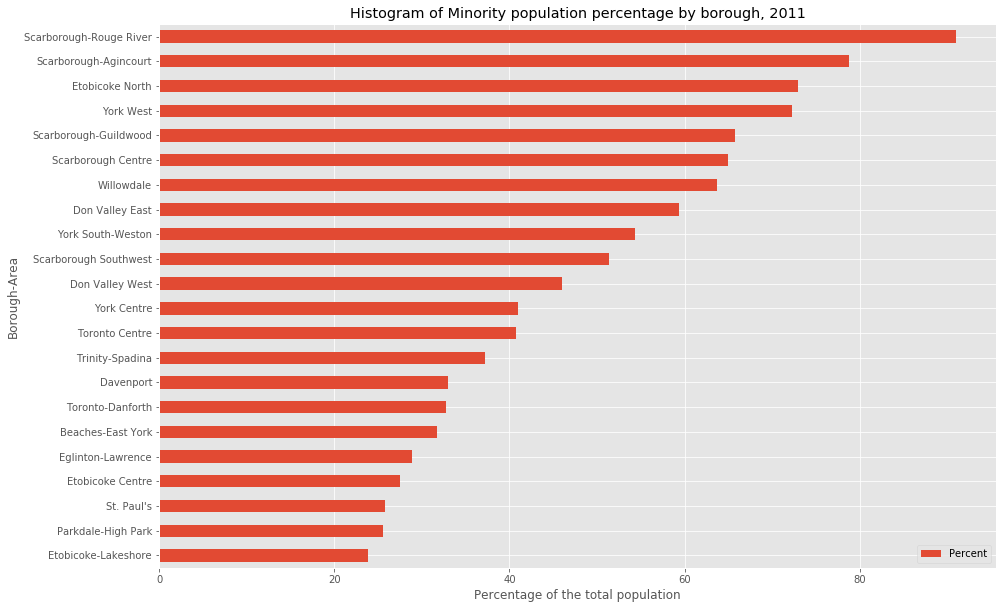

In [21]:
# read in data
df1 = pd.read_csv('minoritypercent.csv').loc[:,['Riding (2003 Redistribution)','2011 NHS']]
df1.rename(columns={'Riding (2003 Redistribution)':'Dist_neig','2011 NHS':'Percent'}, inplace=True)
df1.set_index('Dist_neig')

# plot
df1.plot.barh(x='Dist_neig', figsize=(15, 10))

plt.title('Histogram of Minority population percentage by borough, 2011')
plt.ylabel('Borough-Area')
plt.xlabel('Percentage of the total population')
plt.show()

Bar plot above illustrates the percentage of minority population within each borough, 2011. Overall, boroughs in Toronto have a minority percentage over 20% of the local population, which lends support to the stand that Toronto is an immigration friendly city. Scarborough is the borough with the highest percentage of minority population. Scarborough-Rouge river area is mostly populated with minority groups having minority percentage over 90%, followed by other areas in this borough,  with the least percentage of minority population approximating 50% of local population. Other outstanding borough-area with appreciable number of minority are Etobicoke-North, York-West, and Willowdale, having percentages around 73%, 72%,63%, respectively.  Etobicoke-Centre, Etobicoke-Lakeshore, and PArkdale-High park are among the boroughs with the least minority population, presenting minority percentages less than 30%. As the percentage of minority groups is usually positively associated with the local economy, a big percentage of minority population may help us identify suitable borough to start new business. 

##### 3.2.2 Ethnic percentage in Toronto by group

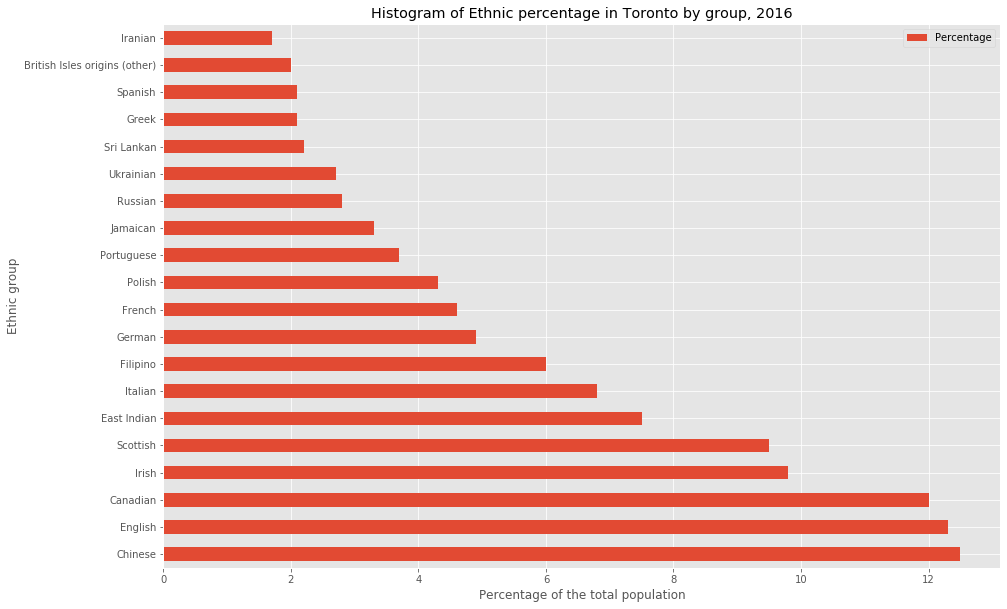

In [15]:
df2 = pd.read_csv('Top 20 Ethnic origins in the City of Toronto.csv').loc[:,['Top 20 Ethnic origins in the City of Toronto','Percentage']]
df2.rename(columns={'Top 20 Ethnic origins in the City of Toronto':'Ethnic group'}, inplace=True)
df2.set_index('Ethnic group')
df2.plot.barh(x='Ethnic group', figsize=(15, 10))

plt.title('Histogram of Ethnic percentage in Toronto by group, 2016')
plt.ylabel('Ethnic group')
plt.xlabel('Percentage of the total population')

plt.show()

As mentioned earlier, an ideal location to start a new restaurant would have a sufficient number of potential customer. Chinese population accounts for over 10 percent of the total population in Toronto, which provides promising prospect and solid support for opening a Chinese restaurant. Meanwhile, other ethnic groups may also provide possible customer as we are vulnerable to great foods. Promising as it seems, I can wait to explore the distribution of Chinese restaurants and population in the City of Toronto.

##### 3.2.3 Correlation between Neighborhood and Chinese restaurant 

In [7]:
can_cordinated = pd.read_csv('can_cordinated.csv').dropna(how='any',axis=0).reset_index(drop=True)
can_cordinated['Bor-Neigh'] = can_cordinated[['Borough','Neighborhood']].apply(lambda x : '{}-{}'.format(x[0],x[1]), axis=1)

Toronto_asianchineserestaurant = pd.read_csv('Toronto_grouped.csv').loc[:,['Neighborhood','Asian Restaurant','Chinese Restaurant']].sort_values(by=['Asian Restaurant','Chinese Restaurant'],ascending=False)
Toronto_asianchineserestaurant1 = Toronto_asianchineserestaurant[Toronto_asianchineserestaurant['Chinese Restaurant']!=0]


df_merge = can_cordinated.merge(Toronto_asianchineserestaurant1, on='Neighborhood',how='inner')#.groupby('Borough').sum()
df_merge.drop_duplicates(subset ="Neighborhood", 
                     keep = 'first', inplace = True)
df_merge1 = df_merge.loc[:,['Bor-Neigh','Asian Restaurant','Chinese Restaurant']]
df_merge1.set_index('Bor-Neigh')

,Asian Restaurant,Chinese Restaurant
Bor-Neigh,,
North York-Don Mills,0.074074,0.037037
"Downtown Toronto-Garden District, Ryerson",0.000000,0.010000
"Downtown Toronto-Harbourfront East, Union Station, Toronto Islands",0.000000,0.010000
North York-Bayview Village,0.000000,0.250000
"Downtown Toronto-Toronto Dominion Centre, Design Exchange",0.010000,0.010000
"Scarborough-Dorset Park, Wexford Heights, Scarborough Town Centre",0.000000,0.166667
Etobicoke-Westmount,0.000000,0.142857
Central Toronto-North Toronto West,0.000000,0.047619
"Downtown Toronto-University of Toronto, Harbord",0.000000,0.029412


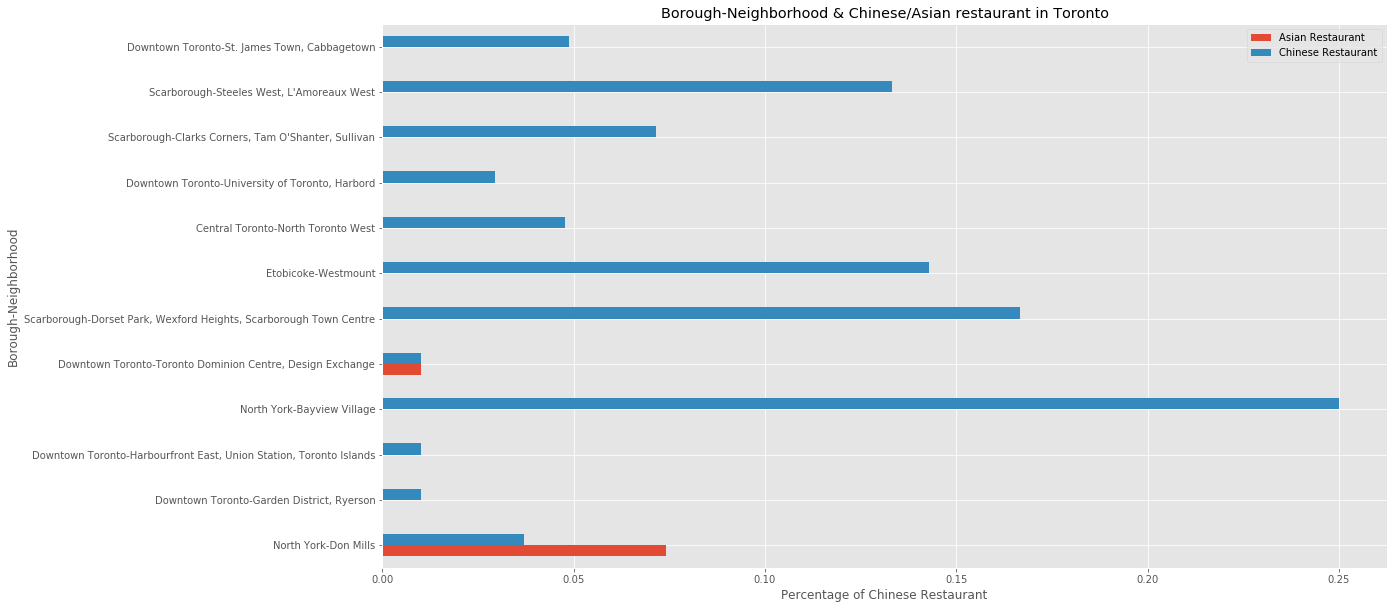

In [9]:
df_merge1.plot.barh(x='Bor-Neigh',figsize=(18, 10))

plt.title('Borough-Neighborhood & Chinese/Asian restaurant in Toronto')
plt.ylabel('Borough-Neighborhood')
plt.xlabel('Percentage of Chinese Restaurant')

plt.show()

Firstly, let's take a look at the distribution of Chinese restaurants. I utilized a bar plot to demonstrate Chinese restaurant distribution by borough-area. Please note, data set used here is derived from [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which is to get dummy variables for coming analysis. Therefore, the percentage here represents the actual frequency of Chinese restaurant after normalization. I have also extracted the distribution of Asian restaurants to help inform potential competition (bars marked in red). Based on bar plot above and early analysis, Scarborough is dominated by minority population and presents the highest frequency of Chinese restaurant. Etobicoke-Westmount and North York-Bayview Village together have around 40 percent of Chinese restaurant city-wide. Another borough that is worth noting is Downtown Toronto. While different areas in this borough alone may present a frequency that is less than 5 percent, summing up all Chinese restaurants in this borough gives us a frequency that is over 10%. Potential competition may present at Downtown Toronto-Toronto Dominian Centre and North York-Don Mills since Asian restaurants are concurrent with Chinese restaurants at these areas.

##### 3.2.3 Correlation between Chinese population and riding/borough-neighborhood 

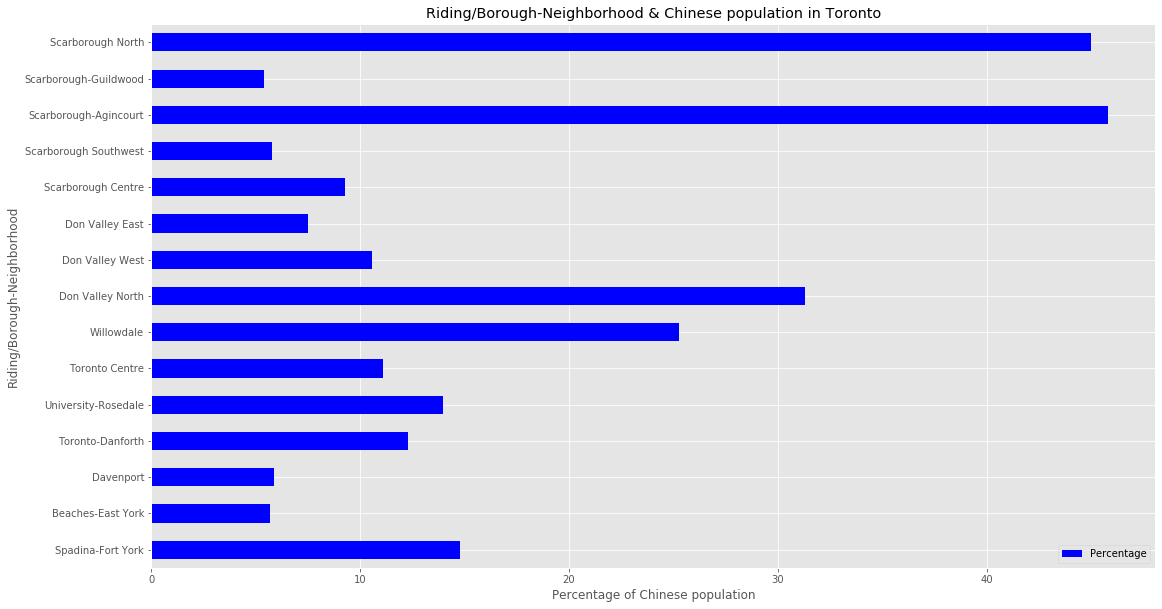

In [69]:
# read in data
df = pd.read_csv('Chinese population by riding.csv',index_col=0)
df1=df.loc[:,['Riding','Percentage']]
df1.head().set_index('Riding')

df1.plot.barh(x='Riding',figsize=(18, 10),color='Blue')

plt.title('Riding/Borough-Neighborhood & Chinese population in Toronto')
plt.ylabel('Riding/Borough-Neighborhood')
plt.xlabel('Percentage of Chinese population')

plt.show()

Next comes the most concerned question: where our potential customer reside? To answer this crucial question, I extract information from demographic information of Toronto and retrieved boroughs-area with Chinese crowd. In Scarborough communities, Chinese accounts for up to more than 45 percent of the area population, especially in the North and Agicourt area. It is safe to say that Chinese are inclined to choose to live in Scarborough borough since we find Chinese a non-trivial part of population constituents in almost all areas across this borough. Another borough with substantial number of Chinese population is Don Valley, in which three areas are reported to have an average of 23 percent of their total population having Chinese origin. Willowdale, University-Rosedale, Toronto centre, Toronto-Danforth, East York, and Fort York have percentage of Chines population ranging from roughly 5% to 15%. 

##### 3.2.3 K-means Clustering & Folium Map
After exploring the distribution of Chinese population and restaurants, I am ready to visualize the distribution of Chinese restaurants in Toronto using K-means clustering and Folium map. Please note, I am going to use part of the Toronto_grouped data with only column Chinese Restaurant and Neighborhood. 

In [ ]:
# set number of clusters arbitarily
kclusters = 6

Toronto_grouped_clustering = pd.read_csv('Toronto_grouped.csv').loc[:,['Neighborhood','Chinese Restaurant']].drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [8]:
# add clustering labels
Toronto_grouped_clustering = pd.read_csv('Toronto_grouped.csv').loc[:,['Neighborhood','Chinese Restaurant']]
Toronto_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = can_cordinated

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(Toronto_grouped_clustering.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Bor-Neigh,Cluster Labels,Chinese Restaurant
0,M3A,North York,Parkwoods,43.753259,-79.329656,North York-Parkwoods,0.0,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,North York-Victoria Village,0.0,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,"Downtown Toronto-Regent Park, Harbourfront",0.0,0.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,"North York-Lawrence Manor, Lawrence Heights",0.0,0.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,"Downtown Toronto-Queen's Park, Ontario Provinc...",0.0,0.0


In [9]:
Toronto_merged=Toronto_merged.dropna()
Toronto_merged['Cluster Labels']= Toronto_merged['Cluster Labels'].astype(int)

In [10]:
Toronto_merged.sort_values('Cluster Labels',ascending=False).head(20)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Bor-Neigh,Cluster Labels,Chinese Restaurant
82,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,"Scarborough-Clarks Corners, Tam O'Shanter, Sul...",5,0.071429
90,M1W,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,"Scarborough-Steeles West, L'Amoreaux West",4,0.133333
70,M9P,Etobicoke,Westmount,43.696319,-79.532242,Etobicoke-Westmount,4,0.142857
39,M2K,North York,Bayview Village,43.786947,-79.385975,North York-Bayview Village,3,0.250000
73,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,Central Toronto-North Toronto West,2,0.047619
80,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,"Downtown Toronto-University of Toronto, Harbord",2,0.029412
7,M3B,North York,Don Mills,43.745906,-79.352188,North York-Don Mills,2,0.037037
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,"Downtown Toronto-St. James Town, Cabbagetown",2,0.048780
13,M3C,North York,Don Mills,43.725900,-79.340923,North York-Don Mills,2,0.037037
65,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,"Scarborough-Dorset Park, Wexford Heights, Scar...",1,0.166667


In [ ]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

In [12]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

First and foremost, I set K=6 arbitrarily and doesn't adopt elbow method to select for the best number of clusters. The reason is that K=6 or 5 would be more than enough to cluster Chinese restaurant into disparate groups based on their frequencies since we have a lot of data points with value=0 if you go back and take a look at the Toronto_merged data set. But I think K=2 would be slightly powerless to differentiate the neighborhoods with relatively high frequency (large numeric value for Chinese restaurant) from the rest, so I just go with K=6 and it turns out to serve my goal perfectly. Dots in red across the map above represents neighborhood having Label level=0, which indicates that there is no or few Chinese restaurant nearby. Dots in other colors, on the other hand, indicate otherwise. Dots in dark green, light green, and purple are labeled with level 3, 4, and 1, respectively and suggest relatively high frequency of Chinese restaurant within the neighborhood. What's left, dots in yellow have label of 5 and those in blue have label of 2, indicating a relatively low frequency of nearby Chinese restaurant. Overall, neighborhood with high frequency of Chinese restaurant are located northeast of the City of Toronto, and Chinese restaurants are also found in neighborhoods between Downtown Toronto and Northeast Toronto with relatively lower frequency.

### 4. Results and discussion

#### 4.1 Results
In this section we will reiterate all the findings made with clustering & visualization of the dataset from different sources. We embark on the journey with question of finding a suitable neighborhood to start a new Chinese restaurant. We looked into the demographics of Toronto, including the percentage of minority group altogether and by borough, the distribution of Chinese restaurant and Chinese population by borough-area to come to conclusion about which neighborhood would be a better choice. Findings are: 
1. Chinese accounts for over **10%** of the population of the City of Toronto, with most of them reside in northeast Toronto boroughs, e.g. Scarborough, providing a substantial customer base for incoming restaurant.
2. In all the boroughs or areas, Chinese restaurants are mainly located **Scarborough, Downtown Toronto, and North Toronto**.
3. In all the boroughs, **Scarborough, Don Valley** are much densely populated with Chinese crowd than the rest; **Willowdale, University-Rosedale, Toronto centre, Toronto-Danforth, East York, and Fort York** are also presenting a substantial number of potential customer.
4. With results of K-means clustering and Folium map, neighborhood with high frequency of Chinese restaurant are located **northeast** of the City of Toronto and **North York-Bayview Village, Etobicoke-Westmount, Scarborough** are already densely populated with Chinese restaurants, which is consistent with finding from using demographic data.

#### 4.2 Discussion
our mission for this project is to identify neighborhood(s) with little competition and sufficient number of customers. The borough and neighborhood of choice should present limited number of existing Chinese restaurant or Asian restaurant while providing a great percentage of minority groups, preferably Chinese. As a large portion of Chinese live in Scarborough and North York (Don Valley), these boroughs are also populated with Chinese restaurants and therefore would not be our option. North York-Willowdale is a better choice than Don Valley since over 25% of the total population in this area Chinese and relatively far from the nearest Chinese restaurants, but it is still risky since neighbor villages, like Bayview Village and Don Valley also found with already populated with Chinese restaurants. Fort York-Spadina is the best location based on the two criteria proposed, with around 15% of its population being Chinese and the close proximity to Chinatown as well as limited number of existing Chinese restaurants nearby. \
\
Main limitations of this analysis include but not limited to: clustering is completely based merely on data obtained from Foursquare API and the demographic data of the distribution of Chinese population in each neighborhood is based on the 2016 census which is not up-to date. Incompleteness of neighborhood information prevents us from getting a more comprehensive image of Toronto neighborhoods. Parameters chosen for API request to Foursquare might pose non-trivial impact on the results, which may need corresponding calibration and adjustment.

### 5. Conclusion

To conclude, I recommend that Fort York-Spadina is the best location to start a new Chinese restaurant, with around 15% of its population being Chinese and the close proximity to Chinatown as well as a limited number of existing Chinese restaurants nearby. This project is meant for potential business investor and those enjoy Web-scraping & Machining Learning & Visualization with Python, and is a preliminary attempt to gain insights into a realistic problem. Please feel free to reach out and share your ideas on this project if any. Find the code in [github](https://github.com/TuoooLiu666/Coursera_Capstone) & find me in [Linkedin](https://www.linkedin.com/in/tuo-liu-491782194/).